In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Load rating data
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'])
df1.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [4]:
# check data types and see if adjustment is needed
df1.dtypes

Cust_Id     object
Rating     float64
dtype: object

In [19]:
# how many movies are there?
n_movies = df1.isnull().sum()[1]
print('# of movies: ',n_movies) # df.isnull().sum() will return the number oF missing values in each column.
# how many customers are there?
n_custs = df1[df1['Rating'].notnull()]['Cust_Id'].nunique()
print('# of customers: ', n_custs)
# How many ratings are there?
n_ratings = df1[df1['Rating'].notnull()].count()[1]
print('# of ratings: ', n_ratings) # df.count() will will return the number oF rows in each column.

# of movies:  4499
# of customers:  470758
# of ratings:  24053764


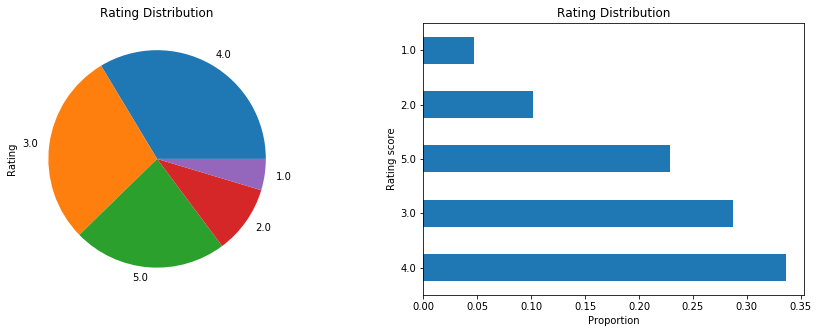

Most ratings are positive, ratings that are 4 or 5 account for 62.0 %


In [41]:
# How are the ratings distributed?
rating_dict = df1[df1['Rating'].notnull()]['Rating'].value_counts()/n_ratings
plt.figure(figsize = [15, 5])
plt.subplot(121)
plt.title('Rating Distribution')
rating_dict.plot.pie()
plt.subplot(122)
plt.title('Rating Distribution')
# Create horizontal bars
rating_dict.plot(kind='barh', legend=None)
plt.xlabel('Proportion')
plt.ylabel('Rating score')
plt.show()

print('Most ratings are positive, ratings that are 4 or 5 account for',round(rating_dict[3]+rating_dict[4],2)*100,'%')


# Data Cleaning and Intergration

## Adjust data structure

In [62]:
df1_na = pd.DataFrame(pd.isnull(df1.Rating))
df1_na = df1_na[df1_na['Rating'] == True]
df1_na = df1_na.reset_index() # the index of original ratings that are NA will be in a separate column

movieid_list = []
movie_id = 1

for i,j in zip(df1_na['index'][1:],df1_na['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)   # np.full(shape, the number you want to fill in those shape)
    movieid_list = np.append(movieid_list, temp)
    movie_id += 1

# Account for last record and corresponding length
last_record = np.full((1,len(df1) - df1_na.iloc[-1, 0] - 1),movie_id)
movieid_list = np.append(movieid_list, last_record)
len(movieid_list)

24053764

In [63]:
df1 = df1[df1['Rating'].notnull()]
df1['Movie_Id'] = movieid_list.astype(int)
df1['Cust_Id'] = df1['Cust_Id'].astype(int)
df1.head()
# df1.to_csv('df1_integrated.csv')

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [2]:
df1 = pd.read_csv('df1_integrated.csv',index = False)
df1 = df1.loc[:, ~df1.columns.str.contains('^Unnamed')]

In [6]:
df1.shape

(24053764, 3)

## Remove unnecessary data

In [7]:
# To clean data and solve computing issues for large dataset:
# 1. Remove movies with too less ratings (less popular movies)
# 2. Remove customers with too less ratings (less active customers)
f = ['count','mean']

df_movie_summary = df1.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df1.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
print('Customer minimum times of review: {}'.format(cust_benchmark))


Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


In [8]:
df1 = df1[~df1['Movie_Id'].isin(drop_movie_list)]
df1 = df1[~df1['Cust_Id'].isin(drop_cust_list)]
print('New dimensions of the dataset: ',df1.shape)

New dimensions of the dataset:  (17337458, 3)


In [9]:
df1.head()

,Cust_Id,Rating,Movie_Id
693,712664,5.0,3
694,1331154,4.0,3
695,2632461,3.0,3
696,44937,5.0,3
697,656399,4.0,3


## Exploratory Data Analysis (EDA)

### Integrate with movie info for EDA

In [12]:
# Get movie information
movie_info = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
movie_info.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [ ]:
df1_full = pd.merge(df1, movie_info, on = 'Movie_Id',how = 'inner')
#df1_full.to_csv('df1_full.csv', index=False)

### Rating Distribution

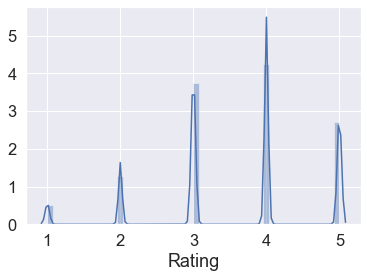

In [98]:
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline
sns.distplot(df1['Rating'])

In [94]:
def eda_histogram(aggregated_df):
    plt.figure(figsize = [16, 12])
    plt.subplot(211)
    sns.distplot(aggregated_df['count'], color = 'b', kde = False)
    plt.title('The number of ratings by {}'.format(aggregated_df.index.name),fontsize=14)
    plt.ylabel('The number of {}'.format(aggregated_df.index.name))
    plt.xlabel('The number of ratings')
    plt.subplot(212)
    sns.distplot(aggregated_df['mean'], color = 'r', kde = False)
    plt.title('The average ratings by {}'.format(aggregated_df.index.name),fontsize=14)
    plt.ylabel('The number of {}'.format(aggregated_df.index.name))
    plt.xlabel('Average Rating')
    plt.show()

def eda_linecharts(aggregated_df):
    plt.figure(figsize = [16, 12])
    plt.subplot(211)
    plt.plot(aggregated_df.index,aggregated_df['count'],'b-')
    plt.title('The number of ratings by {}'.format(aggregated_df.index.name),fontsize=14)
    plt.ylabel('Number of Ratings')
    plt.xlabel(aggregated_df.index.name)
    plt.subplot(212)
    plt.plot(aggregated_df.index,aggregated_df['mean'],'r-')
    plt.title('The average ratings by {}'.format(aggregated_df.index.name),fontsize=14)
    plt.ylabel('Average Ratings')
    plt.xlabel(aggregated_df.index.name)
    plt.show()

### 1. Rating Distribution by Movie

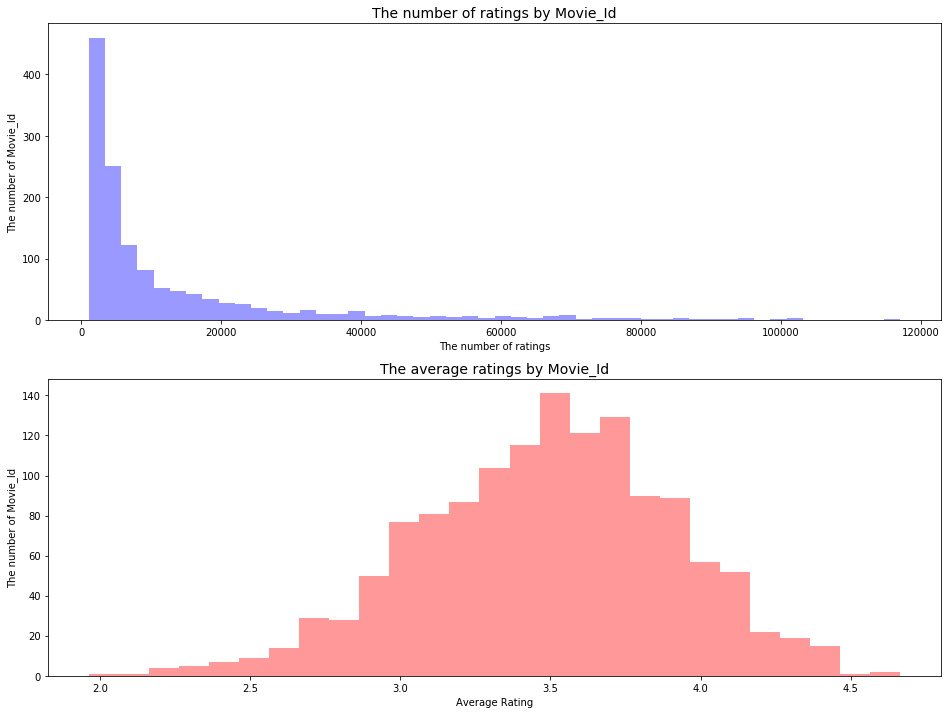

In [90]:
df1_movie = df1_full.groupby('Movie_Id')['Rating'].agg(f)
    
eda_histogram(df1_movie)

### 2. Rating Distribution by User

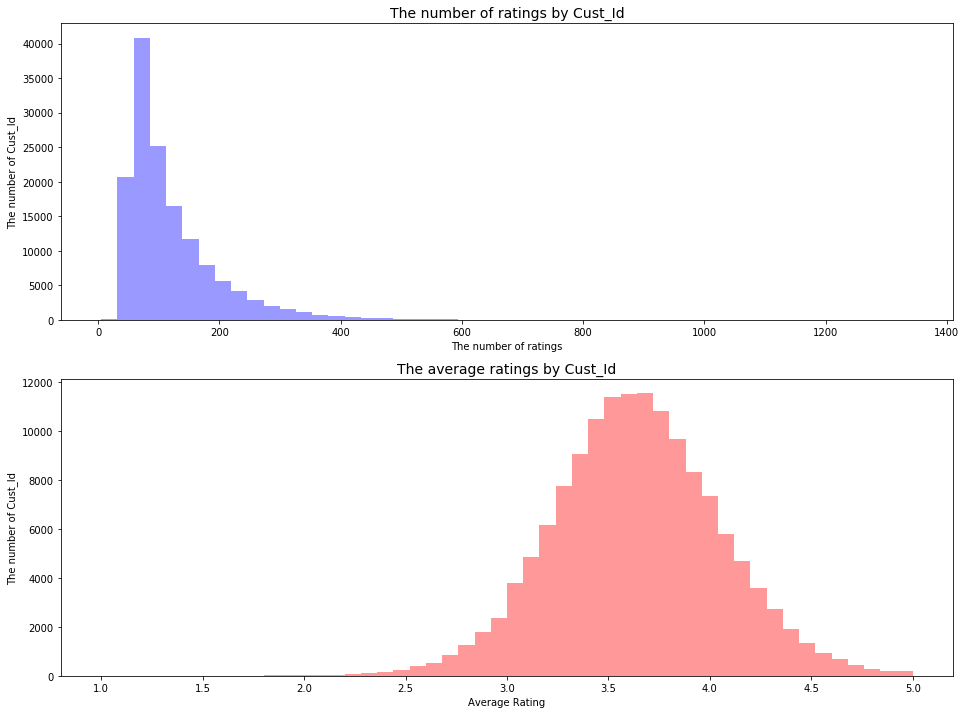

In [91]:
df1_user = df1_full.groupby('Cust_Id')['Rating'].agg(f)

eda_histogram(df1_user)

### 3. Rating Distribution by the movie released year 

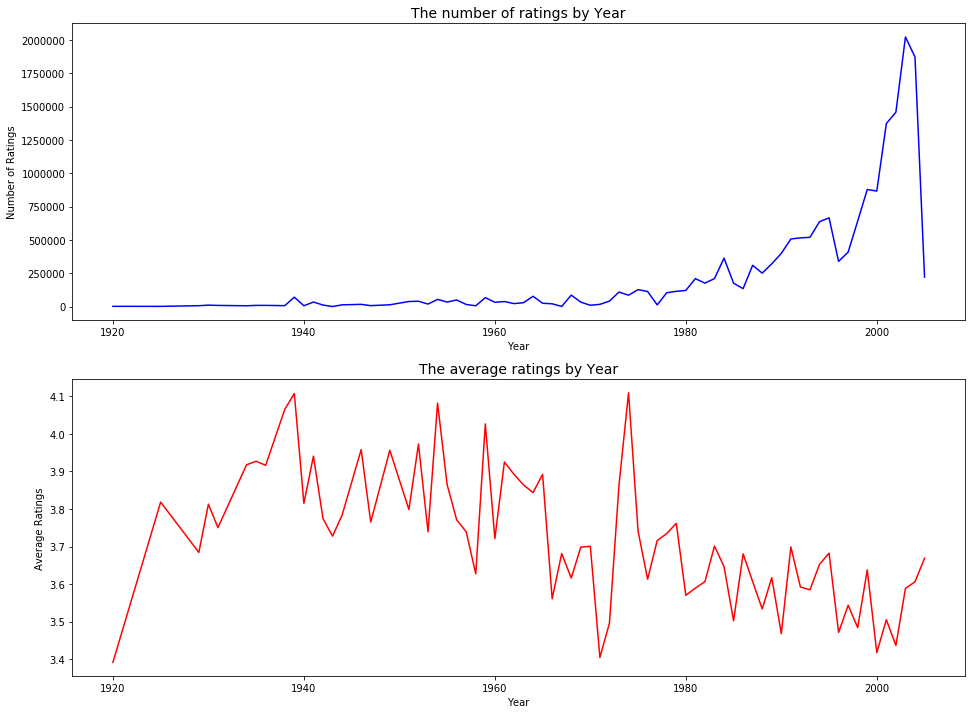

Take-on:
1. The newer the movie, the more ratings there tend to be. 
2. The average rating of old movies are relatively higher than the new ones in general, which might be caused by the fact that there is a much higher number of ratings for new movies.
3. There is a valley of the number of ratings over time that is at the year of 1996
4. The movies released in certain year around 1970 has the lowest average rating. 


In [95]:
# How do the average ratings vary by movie released year?
df1_year = df1_full.groupby('Year')['Rating'].agg(f)

eda_linecharts(df1_year)
print('Take-on:')
print('1. The newer the movie, the more ratings there tend to be. ')
print('2. The average rating of old movies are relatively higher than the new ones in general, which might be caused by the fact that there is a much higher number of ratings for new movies.')
print('3. There is a valley of the number of ratings over time that is at the year of 1996')
print('4. The movies released in certain year around 1970 has the lowest average rating. ')

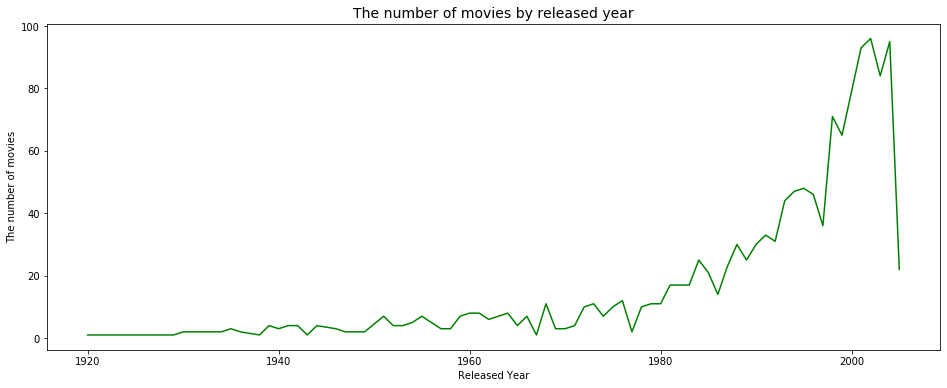

The number of movies released in 1996 is similar as the years around it, which ruled out that reason. The reason why there are less ratings on the movies released in 1996 might be other factors such as movie quality.


In [54]:
# Was the valley of number of ratings caused by less number of movies released at that year?

df1_num = df1_full.groupby('Year')['Movie_Id'].nunique()
plt.figure(figsize = [16, 6])
plt.plot(df1_num.index,df1_num.values, 'g-')
plt.title('The number of movies by released year',fontsize=14)
plt.ylabel('The number of movies')
plt.xlabel('Released Year')
plt.show()
print('The number of movies released in 1996 is similar as the years around it, which ruled out that reason. The reason why there are less ratings on the movies released in 1996 might be other factors such as movie quality.')

In [76]:
# What were the movies that caused a lower average rating on movies released in that year?
## Find the year that has the lowest mean rating within the range of 1960-1980
target_year = df1_year.ix[1960:1980,'mean'].idxmin() 
print('The year that has the lowest mean rating is: ',target_year)
print('-----------')
target_df = df1_full[df1_full['Year'] == target_year]
result1971 = target_df.groupby('Movie_Id')['Rating'].mean()
print(result1971)
print('-----------')
print('Take-on:')
print('4 movies that are released in 1971 are having very low ratings.')

The year that has the lowest mean rating is:  1971.0
-----------
Movie_Id
580     3.107647
1226    3.538188
3331    3.567863
3599    3.606823
Name: Rating, dtype: float64
-----------
Take-on:
4 movies that are released in 1971 are having very low ratings.


C:\Users\olivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


## Movie Titles

Find out what words are popular in movie titles for each rating score.

In [4]:
# could words would be a great visualizaiton for this problem
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

df1_full['Name'] = df1_full['Name'].fillna("").astype('str')
def title_wordcloud(df, ratinglist):
    target_df = df[df['Rating'].isin(ratinglist)]
    title_corpus = ' '.join(target_df['Name'])
    title_wordcloud = WordCloud(stopwords=STOPWORDS, 
                                background_color='black', 
                                height=2000, width=4000).generate(title_corpus)
    # Plot the wordcloud
    plt.figure(figsize=(16,8))
    plt.imshow(title_wordcloud)
    plt.axis('off')
    plt.show()


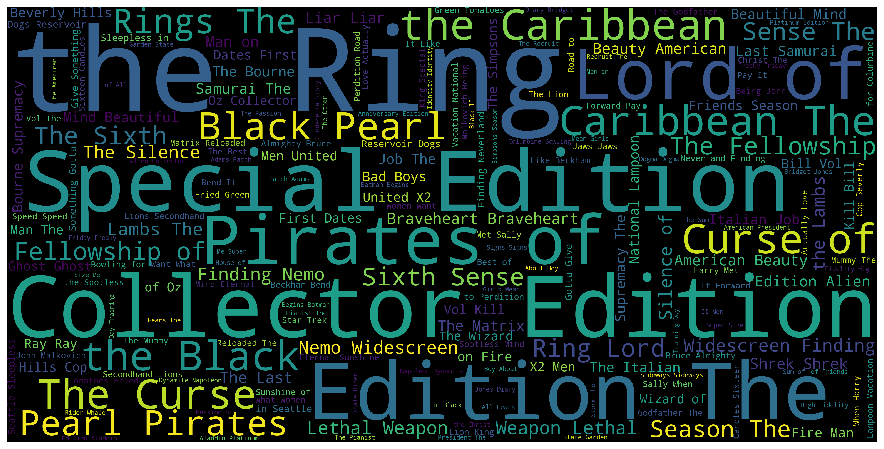

In [5]:
title_wordcloud(df1_full,[4,5])

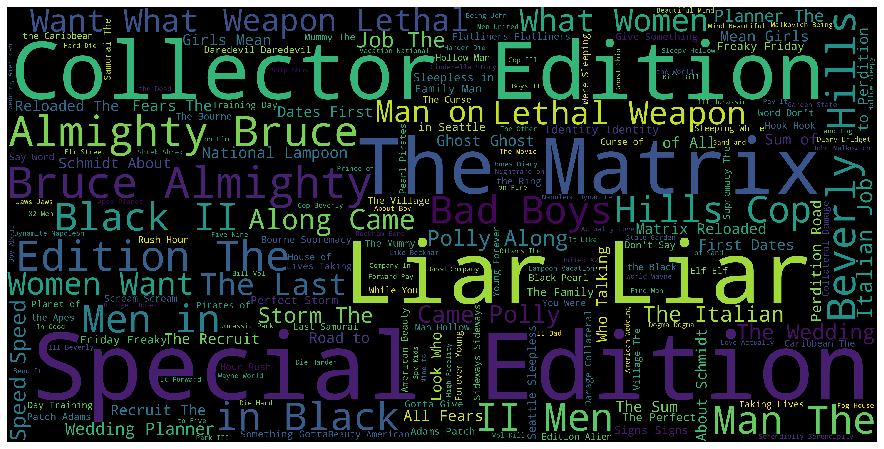

In [6]:
title_wordcloud(df1_full,[3])

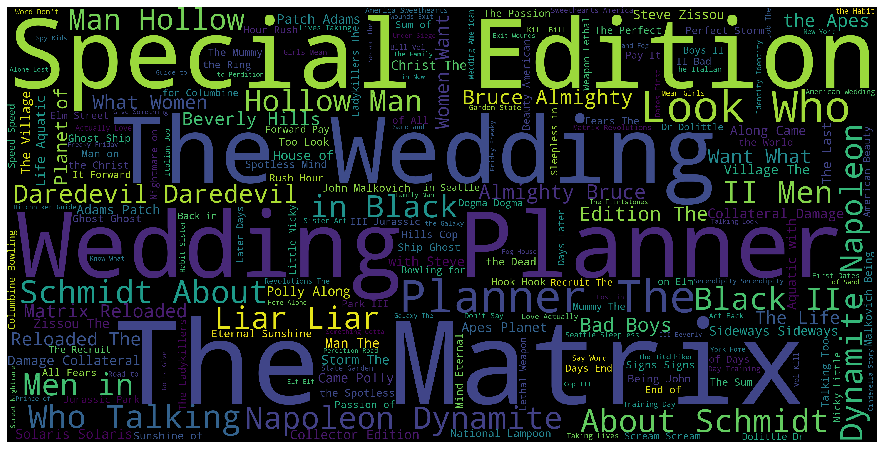

In [7]:
title_wordcloud(df1_full,[1,2])

## Pivot table for RS

In [10]:
# Pivot the table for Recommender System 
df1_ready = pd.pivot_table(df1,values='Rating',index='Cust_Id',columns='Movie_Id')

print('New dimensions of the dataset: ',df1_ready.shape)
#df1_ready.to_csv('df1_pivoted.csv')

New dimensions of the dataset:  (143458, 1350)


# Recommender System Modeling
1. Collaborative Filtering (Surprise or Scikit learn)
2. Content-based 
3. Matrix Factorization

## 1.a Collaborative Filtering using Surprise

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb

In [ ]:
from surprise import Reader, Dataset, SVD, evaluate



## 1.b Collaborative Filtering using Scikit learn
https://github.com/khanhnamle1994/movielens/blob/master/Content_Based_and_Collaborative_Filtering_Models.ipynb